In [1]:
import matplotlib.pyplot as plt
import numpy as np # should be 1.19
import os
import PIL # load images
import tensorflow as tf # tf 2.5.0

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib # similar to os
import keras_tuner as kt # for tuning hyperparameters

# import seaborn as sns //install sklearn and scipy 
# sns.set() //cannot import name 'distance' from 'scipy.spatial' (unknown location)class_names = train_ds.class_names

### Load dataset

In [2]:
# Import path Food101 dataset
# https://www.kaggle.com/kmader/food41?select=images 
data_dir = pathlib.Path(str(pathlib.Path.cwd()) + '/food101/sub_images')
data_dir

PosixPath('/Users/alicis/Documents/WorkProjects/Image_classification/food101/sub_images')

In [3]:
# Show image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10000


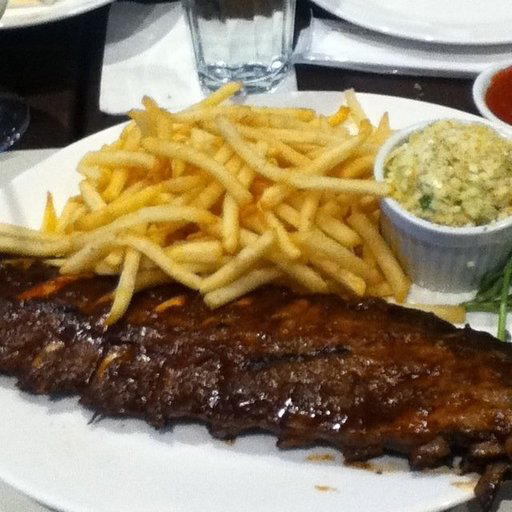

In [4]:
# Show example img
roses = list(data_dir.glob('baby_back_ribs/*'))
PIL.Image.open(str(roses[3])) # Open path roses[0]

### Split dataset

In [5]:
# Intialize parameter
batch_size = 10 # update every n 
img_height = 180 # resize images height
img_width = 180

In [6]:
# training dataset 80%
train_ds = tf.keras.preprocessing.image_dataset_from_directory( # Shuffle everytime the variable is called
    data_dir,
    validation_split=0.2,
    subset="training", # type of spliting
    seed=123, # same spilt
    image_size=(img_height,img_width), # Reshape images
    batch_size=batch_size # update size
)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


In [7]:
# validation dataset 20%
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


### Show splited dataset 

In [8]:
with open('food101/meta/sub_classes.txt','r') as f:
    class_names = f.read().splitlines() #f.readlines() for included \n
len(class_names)    

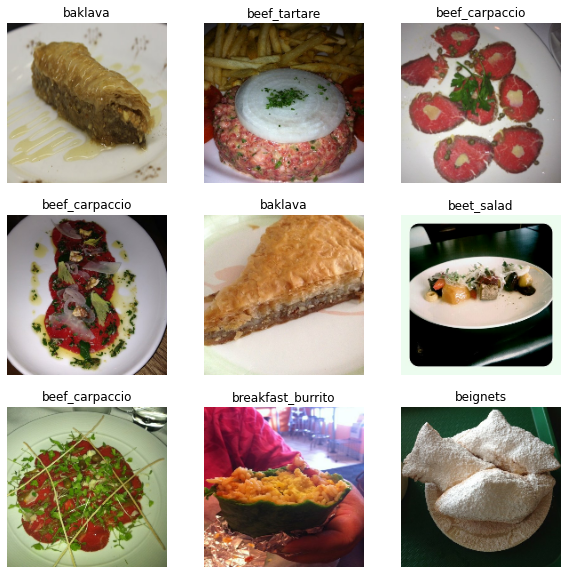

In [10]:
# visualize multiple images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# Check image shape/size
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 180, 180, 3)
(10,)


### Configure the dataset for performance

In [12]:
# To yield data from disk without I/O become blocking, buffered prefetching are implemented
# train and val buffer size (https://stackoverflow.com/questions/47781375/tensorflow-dataset-shuffle-large-dataset)
AUTOTUNE = tf.data.AUTOTUNE # autotune buffersize

# cache(): keeps the images in memory after they're loaded off disk during the first epoch
# prefetch(): overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [ ]:
# Extract image and lable from batch tensors
# y = np.concatenate([y for x, y in train_ds], axis=0) for additional method
for images, labels in train_ds:  # only take first element of dataset
    train_images = images.numpy()
    label_train = labels.numpy()

### Additional dataset

In [19]:
# Add more sample
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

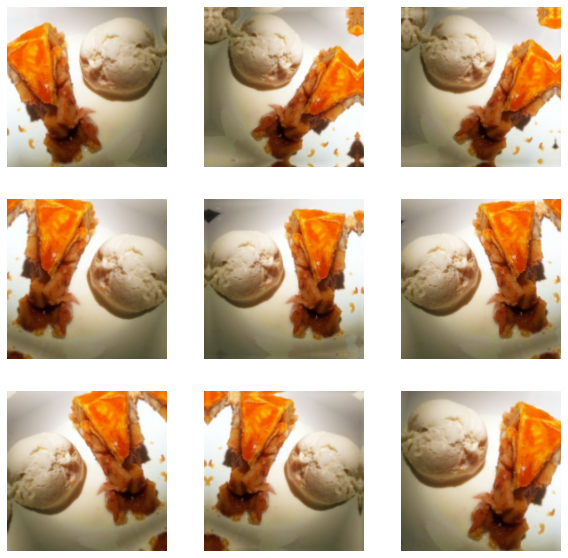

In [20]:
# Plot augmentation data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Model builder

In [56]:
num_classes = len(class_names) # number of classes

def model_builder(hp): # build model
    model = keras.Sequential()
    model.add(data_augmentation) # add more sample/training data
    model.add(layers.experimental.preprocessing.Rescaling(1./255), input_shape=(img_height, img_width, 3)) # normalization
    
    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu')) # same: case-sensitive
    model.add(layers.MaxPooling2D((2, 2))) 
    
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.2)) # Prevent overfitting
    model.add(layers.Flatten())
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 128-512
    hp_units = hp.Int('units', min_value=160, max_value=256, step=32)
    hp_drop_rate = hp.Choice('drop_rate', values=[0.2, 0.5])
    
    model.add(layers.Dense(hp_units, activation='relu'))
    
    model.add(layers.Dropout(hp_drop_rate))
    
    model.add(layers.Dense(num_classes))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [73]:
# from_logits=True means the input to crossEntropy layer is normal tensor/logits, while if from_logits=False, 
# means the input is a probability and usually you should have some softmax activation in your last layer.
# https://stackoverflow.com/questions/57253841/from-logits-true-and-from-logits-false-get-different-training-result-for-tf-loss

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True) # Overwirte exist project

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

### Search for optimal hyperparameters

In [74]:
# Search for optimal hyperparameter
tuner.search(train_ds, validation_data=val_ds, epochs=30, callbacks=[stop_early])

Trial 30 Complete [00h 19m 47s]
val_accuracy: 0.10750000178813934

Best val_accuracy So Far: 0.5205000042915344
Total elapsed time: 03h 59m 39s
INFO:tensorflow:Oracle triggered exit


In [75]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} best drop_rate {best_hps.get('drop_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.001 best drop_rate 0.5.



In [76]:
model.save('modev0l')

INFO:tensorflow:Assets written to: modev0l/assets


### Train the model

In [79]:
# Apply optimal parameter to model
epochs = 50;

model = tuner.hypermodel.build(best_hps)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/60
800/800 [==============================] - 119s 148ms/step - loss: 2.0148 - accuracy: 0.2824 - val_loss: 1.8028 - val_accuracy: 0.3885
Epoch 2/60
800/800 [==============================] - 116s 145ms/step - loss: 1.7604 - accuracy: 0.3857 - val_loss: 1.6132 - val_accuracy: 0.4330
Epoch 3/60
800/800 [==============================] - 118s 148ms/step - loss: 1.6685 - accuracy: 0.4156 - val_loss: 1.4913 - val_accuracy: 0.4825
Epoch 4/60
800/800 [==============================] - 119s 149ms/step - loss: 1.5699 - accuracy: 0.4480 - val_loss: 1.4759 - val_accuracy: 0.4935
Epoch 5/60
800/800 [==============================] - 118s 148ms/step - loss: 1.5172 - accuracy: 0.4646 - val_loss: 1.4660 - val_accuracy: 0.4930
Epoch 6/60
800/800 [==============================] - 119s 148ms/step - loss: 1.4949 - accuracy: 0.4781 - val_loss: 1.4166 - val_accuracy: 0.5070
Epoch 7/60
800/800 [==============================] - 118s 148ms/step - loss: 1.4599 - accuracy: 0.4866 - val_loss: 1.4793 -

Epoch 57/60
800/800 [==============================] - 140s 175ms/step - loss: 0.9947 - accuracy: 0.6440 - val_loss: 1.5165 - val_accuracy: 0.5710
Epoch 58/60
800/800 [==============================] - 143s 179ms/step - loss: 0.9725 - accuracy: 0.6479 - val_loss: 1.5367 - val_accuracy: 0.5790
Epoch 59/60
800/800 [==============================] - 141s 176ms/step - loss: 0.9718 - accuracy: 0.6520 - val_loss: 1.4776 - val_accuracy: 0.5745
Epoch 60/60
800/800 [==============================] - 140s 175ms/step - loss: 0.9930 - accuracy: 0.6499 - val_loss: 1.3960 - val_accuracy: 0.5770
Best epoch: 50


### Visualize training results

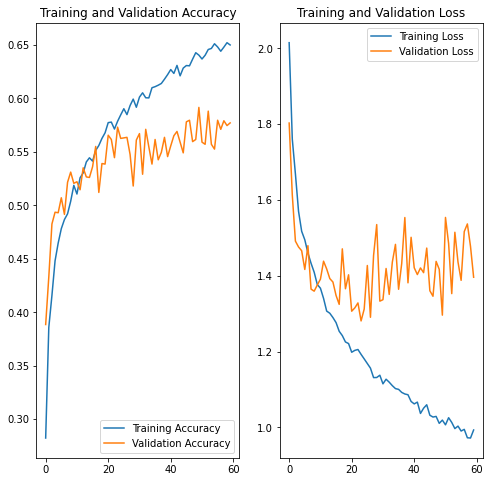

In [83]:
# Compare result 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [84]:
# Save model
model.save('food_mode01072021')

INFO:tensorflow:Assets written to: food_mode01072021/assets


In [87]:
# predict the calculate score
predictions = model.predict(val_ds)

score = tf.nn.softmax(predictions[50])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to bread_pudding with a 36.01 percent confidence.
